# 映画の推薦システム
* ここでは推薦アルゴリズムの勉強のために、映画データをもとにした推薦システムを実装する。
* なお、書籍[仕事ではじめる機械学習](http://amzn.to/2DKKS2g)と、Chap7の[GitHubレポジトリ](https://github.com/oreilly-japan/ml-at-work/blob/master/chap07/Movie_recommendation.ipynb)を参考にしている。
* ここでは`fastFM`というライブラリを用いて、`Factorization Machines`というアルゴリズムで推薦を実装する。

## Factorization Machinesとは
* まず、`Matrix Factorization`というものがある。これは、レーティングの評価行列を、ユーザーの行列とアイテムの行列で表現すること。
    * m x nの評価行列R（m人のユーザー、nこのアイテム）がある時に、これをユーザー行列Uとアイテム行列Iに分解する。
    * このとき、Rは疎な行列。
    * U,Iは密な行列
* 上記の`Matrix Factorization`を一般化したのが`Factorization Machines`。

## Factorization Machinesの特徴
* ユーザーとアイテムの情報以外の特徴量も扱うことができる。
* `Matrix Factorization`と同じく疎な行列を扱うことができる。
* 特徴量の間で影響を与え合う交互作用（Interaction）を考慮することができるので、相関関係がある特徴量も適切に扱うことができる。

## fastFMの動作確認

In [1]:
from sklearn.model_selection import learning_curve
import numpy as np
from fastFM import als

from sklearn.feature_extraction import DictVectorizer

train = [
    {"user":"1", "item":"5","age":19},
    {"user":"2", "item":"43","age":33},
    {"user":"3", "item":"20","age":55},
    {"user":"4", "item":"10","age":20},
]

In [2]:
v = DictVectorizer()
X = v.fit_transform(train)
X.toarray()

array([[19.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [33.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
       [55.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

* `DictVectorizer`は文字列型をOneHotに変更してくれるようだ。

In [3]:
y = np.array([5.0, 1.0, 2.0, 4.0])
y

array([5., 1., 2., 4.])

In [4]:
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=2, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(X,y)
fm.predict(v.transform({"user":"5","item":"10", "age":24}))

array([3.60775939])

* 上記では、年齢が24歳の人が`item=10`に幾つのスコアをつけるか予想している。結果は`3.6`。`user=4`の方が年齢20歳で、 `item=10`に`4`というスコアをつけているため、納得感がある。

## データの探索的分析

In [8]:
import pandas as pd

# user情報
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv("ml-100k/u.user", sep="|", names=u_cols)

In [9]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [10]:
# レーティング情報
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=r_cols)
ratings["date"] = pd.to_datetime(ratings["unix_timestamp"], unit="s")

In [11]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16


In [12]:
# 映画情報
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv("ml-100k/u.item", sep="|", names=m_cols, usecols=range(5), encoding="latin1")

In [13]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [14]:
# 3つをマージ
movie_rating = pd.merge(movies, ratings)
lens = pd.merge(movie_rating, users)
lens.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,date,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,1998-02-17 18:20:08,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,1998-02-17 18:07:27,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,1998-02-17 17:31:36,60,M,retired,95076


In [17]:
# 評価件数の多い作品
lens.title.value_counts()[:25]

Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Back to the Future (

In [20]:
movie_stats = lens.groupby("title").agg({"rating":[np.size, np.mean]})
movie_stats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

In [23]:
# 評価の高いもの
movie_stats.sort_values(by=[('rating','mean')],ascending=False).head()

rating     
                                             size mean
title                                                 
They Made Me a Criminal (1939)                  1  5.0
Marlene Dietrich: Shadow and Light (1996)       1  5.0
Saint of Fort Washington, The (1993)            2  5.0
Someone Else's America (1995)                   1  5.0
Star Kid (1997)                                 3  5.0

In [28]:
# 100件以上の評価がされていて評価が高いもの
atleast_100 = movie_stats["rating"]["size"]>100
movie_stats[atleast_100].sort_values(by=[("rating","mean")],ascending=False).head()

rating          
                                   size      mean
title                                            
Close Shave, A (1995)               112  4.491071
Schindler's List (1993)             298  4.466443
Wrong Trousers, The (1993)          118  4.466102
Casablanca (1942)                   243  4.456790
Shawshank Redemption, The (1994)    283  4.445230

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

In [48]:
lens.groupby(by="user_id")["movie_id"].count().sort_values(ascending=False).head()

user_id
405    737
655    685
13     636
450    540
276    518
Name: movie_id, dtype: int64

Text(0,0.5,'user count')

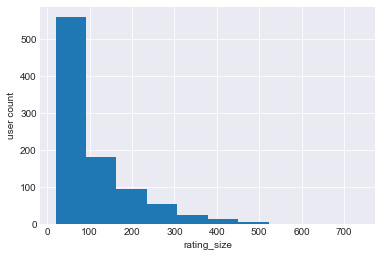

In [46]:
lens.groupby(by="user_id")["movie_id"].count().sort_values(ascending=False).hist()
plt.xlabel("rating size")
plt.ylabel("user count")

In [51]:
user_stats = lens.groupby("user_id").agg({"rating":[np.size,np.mean]})

In [52]:
user_stats.describe()

rating            
             size        mean
count  943.000000  943.000000
mean   106.044539    3.588191
std    100.931743    0.445233
min     20.000000    1.491954
25%     33.000000    3.323054
50%     65.000000    3.620690
75%    148.000000    3.869565
max    737.000000    4.869565

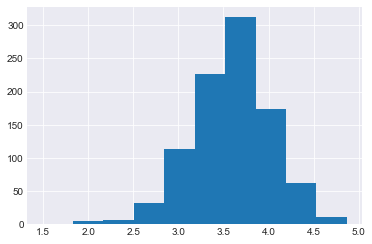

In [60]:
user_stats["rating"]["mean"].hist()

## MovieLensデータの予測モデルの構築
* fastFMを用いて予測をモデルを構築していく。

### データのロード
* データを開発データ（学習データ、検証データ）、テストデータに分割。
* ユーザID、映画IDのダミー変数化をする。

In [61]:
def loadData(filename, path="ml-100k/"):
    data = []
    y = []
    users = set()
    items = set()
    with open(path+filename) as f:
        for line in f:
            (user, movieid, rating, ts) = line.split("\t")
            data.append({"user_id": str(user), "movie_id":str(movieid)})
            y.append(float(rating))
            users.add(user)
            items.add(movieid)
            
    return (data, np.array(y), users, items)

In [62]:
(dev_data, y_dev, dev_users, dev_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

In [63]:
from sklearn.model_selection import train_test_split

v = DictVectorizer()
X_dev = v.fit_transform(dev_data)
X_test = v.transform(test_data)
np.std(y_test)
X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_dev, y_dev, 
                                                            test_size=0.1,random_state=42)

### イテレーション回数の影響
* ここではfastFMのMCMCを用いる。
* 長所：ハイパーパラメータの数が少ない、自動で正則化できる
* 短所：学習に一定の時間が必要

In [70]:
from sklearn.metrics import mean_squared_error
from fastFM import mcmc

n_iter = 300
step_size = 1
seed = 123
rank = 4

fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)

fm.fit_predict(X_train, y_train, X_dev_test)

rmse_dev_test = []
rmse_test = []
hyper_param = np.zeros((n_iter-1,3+2*rank), dtype=np.float64)

for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i*seed
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_dev_test)))
    hyper_param[nr,:] = fm.hyper_param_
    
values = np.arange(1, n_iter)
x = values * step_size
burn_in = 5
x = x[burn_in:]

0.8959692745565979


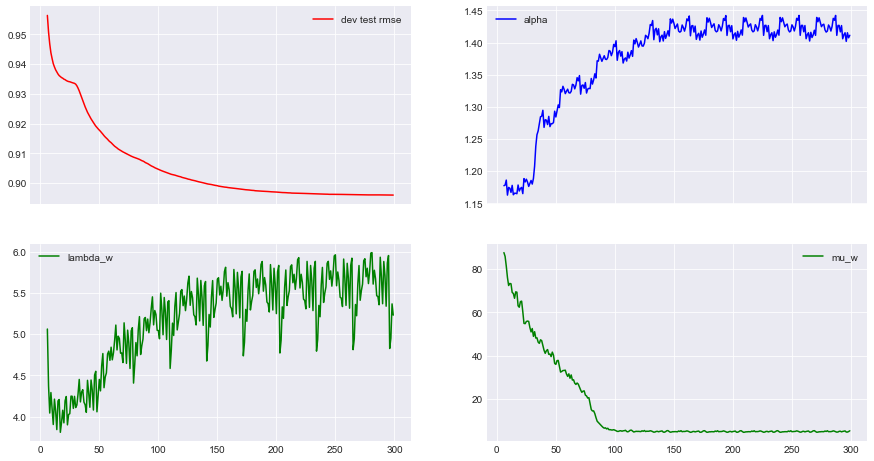

In [76]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15,8))

axes[0,0].plot(x, rmse_test[burn_in:], label="dev test rmse", color="r")
axes[0,0].legend()
axes[0,1].plot(x, hyper_param[burn_in:,0], label="alpha", color="b")
axes[0,1].legend()
axes[1,0].plot(x, hyper_param[burn_in:,1], label="lambda_w",color="g")
axes[1,0].legend()
axes[1,1].plot(x, hyper_param[burn_in:,3], label="mu_w", color="g")
axes[1,1].legend()

print(np.min(rmse_test))

In [77]:
n_iter = 100
rank = 4
seed = 333
step_size = 1

fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)

fm.fit_predict(X_train, y_train, X_dev_test)

rmse_test = []
rmse_news = []
hyper_param = np.zeros((n_iter-1, 3+2*rank), dtype=np.float64)
for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i*seed
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred,y_dev_test)))
    hyper_param[nr,:] = fm.hyper_param_

----------restart----------
iter:10 rmse:0.941
iter:20 rmse:0.935
iter:30 rmse:0.934
iter:40 rmse:0.932
iter:50 rmse:0.923
iter:60 rmse:0.917
iter:70 rmse:0.913
iter:80 rmse:0.909
iter:90 rmse:0.906


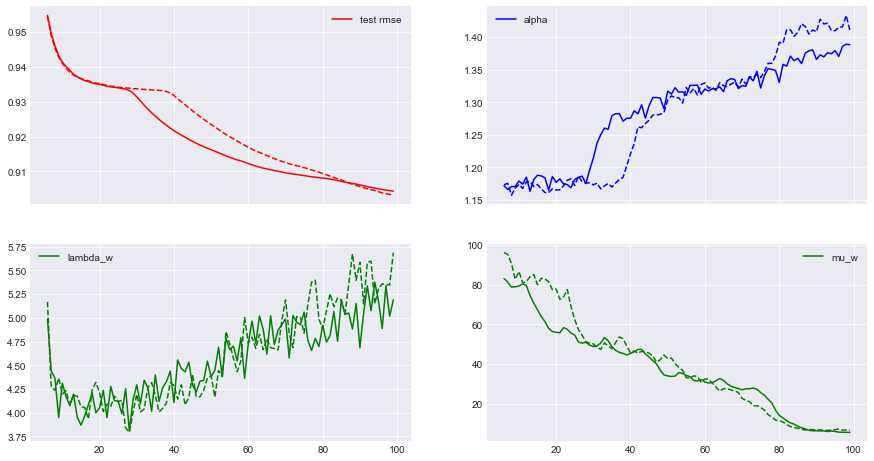

min rmse: 0.903


In [78]:
print("----------restart----------")

values = np.arange(1, n_iter)
rmse_test_re = []
hyper_param_re = np.zeros((len(values), 3+2*rank), dtype=np.float64)

for nr, i in enumerate(values):
    fm = mcmc.FMRegression(n_iter=i, rank=rank, random_state=seed)
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_dev_test))
    rmse_test_re.append(rmse)
    hyper_param_re[nr, :] = fm.hyper_param_
    if i % 10 == 0:
        print('iter:{} rmse:{:.3f}'.format(i, rmse))

from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

x = values * step_size
burn_in = 5
x = x[burn_in:]

#with plt.style.context('ggplot'):
axes[0, 0].plot(x, rmse_test[burn_in:], label='test rmse', color="r")
axes[0, 0].plot(values[burn_in:], rmse_test_re[burn_in:], ls="--", color="r")
axes[0, 0].legend()

axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
axes[0, 1].plot(values[burn_in:], hyper_param_re[burn_in:,0], ls="--", color="b")
axes[0, 1].legend()

axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
axes[1, 0].plot(values[burn_in:], hyper_param_re[burn_in:,1], ls="--", color="g")
axes[1, 0].legend()

axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
axes[1, 1].plot(values[burn_in:], hyper_param_re[burn_in:,3], ls="--", color="g")
axes[1, 1].legend()

plt.show()
print("min rmse: {:.3f}".format(np.min(rmse_test_re)))

### Rankの影響
* rankは行列を圧縮する次数。